# Statistics

> Scripts to generate statistics out of orbit data

In [ ]:
#| default_exp stats

In [ ]:
#| export
#| hide
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional

In [ ]:
#| hide
from fastcore.test import test_eq

In [ ]:
#| test
from orbit_generation.data import get_example_orbit_data

In [ ]:
#| test
orbit_data = get_example_orbit_data()
orbit_data.shape

(400, 7, 100)

## Simple statistics

In [ ]:
#| export
def calculate_overall_spatial_statistics(
    orbits: np.ndarray,  # Array of shape (number_of_orbits, 6 or 7, number_of_time_instants) containing orbit data
) -> np.ndarray:
    """
    Calculate the overall min, mean, max, and percentile statistics for each scalar 
    (position and velocity in X, Y, Z) across all time instants and orbits.
    """
    stats = []  # List to store statistics for each scalar.
    scalar_names = ['posx', 'posy', 'posz', 'velx', 'vely', 'velz']  # List of scalar names.
    
    # Check if the first dimension is for time
    if orbits.shape[1] == 7:
        scalar_names.insert(0, 'time')  # Add time as the first scalar if present.

    # Calculate statistics for each scalar
    for scalar_index, scalar_name in enumerate(scalar_names):
        if 'time' in scalar_names and scalar_name == 'time':
            continue  # Skip time in the calculations for statistics.

        # Flatten data across orbits and time points
        scalar_data = orbits[:, scalar_index, :].flatten()

        # Calculate statistics and append to the list
        scalar_stats = [
            np.min(scalar_data),
            np.mean(scalar_data),
            np.max(scalar_data),
            np.percentile(scalar_data, 25),
            np.median(scalar_data),
            np.percentile(scalar_data, 75)
        ]
        stats.append(scalar_stats)

    return np.array(stats)

In [ ]:
#| test "basic functionality"
orbits = np.array([
    [[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]],  # Orbit 1
    [[4, 4, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9]]   # Orbit 2
])

# Call the function to calculate statistics
stats = calculate_overall_spatial_statistics(orbits)

# Define the expected values for each statistic
expected_stats = np.array([
    [1, 3, 4, 2.25, 3.5, 4],    # posx
    [2, 3.5, 5, 3, 3.5, 4],     # posy
    [3, 4.5, 6, 4, 4.5, 5],     # posz
    [4, 5.5, 7, 5, 5.5, 6],     # velx
    [5, 6.5, 8, 6, 6.5, 7],     # vely
    [6, 7.5, 9, 7, 7.5, 8]      # velz
])

# Test each statistic for each scalar
for i, scalar_name in enumerate(['posx', 'posy', 'posz', 'velx', 'vely', 'velz']):
    test_eq(stats[i, 0], expected_stats[i, 0])
    test_eq(stats[i, 1], expected_stats[i, 1])
    test_eq(stats[i, 2], expected_stats[i, 2])
    test_eq(stats[i, 3], expected_stats[i, 3])
    test_eq(stats[i, 4], expected_stats[i, 4])
    test_eq(stats[i, 5], expected_stats[i, 5])

In [ ]:
#| export
def calculate_per_orbit_spatial_statistics(orbits: np.ndarray,  # A numpy array of shape (number_of_orbits, 6 or 7, number_of_time_instants) containing orbit data
                                         ) -> np.ndarray:
    """
    Calculate per-orbit min, mean, max, and percentile statistics for each scalar (position and velocity in X, Y, Z) across all time instants.
    """
    stats = []  # List to store statistics for each orbit.
    scalar_names = ['posx', 'posy', 'posz', 'velx', 'vely', 'velz']  # List of scalar names.
    num_stats = 6  # min, mean, max, 25th percentile, median, 75th percentile

    # Check if the second dimension includes time
    if orbits.shape[1] == 7:
        scalar_names.insert(0, 'time')  # Add 'time' as the first scalar if present.

    num_orbits = orbits.shape[0]
    num_scalars = len(scalar_names) - 1 if 'time' in scalar_names else len(scalar_names)
    num_stats = 6  # min, mean, max, 25th percentile, median, 75th percentile

    # Iterate over each orbit
    for orbit_index in range(num_orbits):
        orbit_stats = []  # List to store stats for all scalars in the current orbit

        for scalar_index, scalar_name in enumerate(scalar_names):
            if 'time' in scalar_names and scalar_name == 'time':
                continue  # Skip 'time' scalar if present

            # Extract scalar data for the current orbit
            scalar_data = orbits[orbit_index, scalar_index, :]

            # Calculate statistics
            scalar_stats = [
                np.min(scalar_data),
                np.mean(scalar_data),
                np.max(scalar_data),
                np.percentile(scalar_data, 25),
                np.median(scalar_data),
                np.percentile(scalar_data, 75)
            ]
            orbit_stats.append(scalar_stats)

        stats.append(orbit_stats)

    return np.array(stats)

## Plot Time

In [ ]:
#| export
def plot_time_increments(orbit_dataset: np.ndarray,  # The 3D numpy array representing the orbits
                         orbits_to_plot: Optional[List[int]] = None,  # Optional list of integers referring to the orbits to plot
                         show_legend: bool = True  # Boolean to control the display of the legend
                        ) -> None:
    """
    Plots the time as a function to visualize how it increments for each orbit.
    """
    num_orbits = orbit_dataset.shape[0]

    # If orbits_to_plot is not provided, plot all orbits
    if orbits_to_plot is None:
        orbits_to_plot = list(range(num_orbits))

    plt.figure(figsize=(10, 6))

    for i in orbits_to_plot:
        time_steps = orbit_dataset[i, 0]  # Extract the time steps for the current orbit
        plt.plot(time_steps, label=f'Orbit {i}')

    plt.xlabel('Time Step Index')
    plt.ylabel('Time')
    plt.title('Time Increments for Orbits')
    
    if show_legend:
        plt.legend()
    
    plt.grid(True)
    plt.show()

## Plot Histograms

In [ ]:
#| export
def plot_orbit_data_lengths(orbit_data: Dict[int, np.ndarray],  # Dictionary mapping orbit IDs to orbit data arrays
                          key_range: Tuple[int, int] = (1, 36072),  # Range of orbit IDs to analyze (start, end)
                          dimension: int = 0,  # Dimension of the orbit data to measure length
                          bins: int = 30,  # Number of bins for histogram
                          color: str = 'blue',  # Color of histogram bars
                          plot: bool = True,  # Whether to plot the histogram
                          title: str = 'Histogram of Orbits Time Steps'  # Title of the plot
                          ) -> Optional[List[int]]:
    """
    Analyzes and optionally plots the distribution of time steps across multiple orbits.
    Returns the list of lengths if plot=False, otherwise displays histogram and returns None.
    """
    lengths = []
    
    # Iterate over each dataset name within the provided range
    start, end = key_range  # Unpack the tuple for range
    for key in range(start, end):
        if key in orbit_data:
            try:
                # Append the length of the specified dimension of the dataset
                lengths.append(len(orbit_data[key][dimension]))
            except IndexError:
                # Handle the case where the dimension is not available
                print(f"Warning: Dimension {dimension} is not available in dataset {key}.")
                continue
    
    if plot:
        # Plot the histogram of these lengths if plot is True
        plt.figure(figsize=(10, 6))
        plt.hist(lengths, bins=bins, color=color, edgecolor='black')
        plt.title(title)
        plt.xlabel('Time Steps')
        plt.ylabel('Frequency')
        plt.show()
    else:
        # Return lengths data for further analysis
        return lengths

In [ ]:
#| export
def plot_histograms_position(data: np.ndarray,  # The orbit data array of shape (num_orbits, num_scalars, num_time_points)
                           save_path: Optional[str] = None,  # Optional path to save the plot image
                           last_time_elements: bool = True,  # Whether to plot only the last elements of the time vectors
                           ) -> None:
    """
    Plots histograms for the scalar values (position and velocity in X, Y, Z, and optionally time) across all orbits
    and time points. Handles arrays with 6 or 7 scalar dimensions, with the 7th being 'time'.
    """
    # Check the number of scalars and adjust scalar names accordingly
    num_scalars = data.shape[1]
    if num_scalars == 7:
        scalar_names = ['time', 'posX', 'posY', 'posZ', 'velX', 'velY', 'velZ']
    elif num_scalars == 6:
        scalar_names = ['posX', 'posY', 'posZ', 'velX', 'velY', 'velZ']
    else:
        raise ValueError("Data arrays must have either 6 or 7 scalar dimensions.")

    # Setting up the subplot grid, dynamically adjusting if we have 7 scalars
    rows, cols = (3, 3) if num_scalars == 7 else (2, 3)
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust height based on rows
    fig.suptitle('Histograms of Position, Velocity Components, and Time (if present) Across All Orbits')
    
    for i in range(num_scalars):
        if i == 0 and num_scalars == 7 and last_time_elements:
            # Plot only the last elements of the time vectors
            scalar_values = data[:, i, -1]  # Last elements of the time vectors
        else:
            # Flatten combines all orbits and time points for each scalar
            scalar_values = data[:, i, :].flatten()
        
        row, col = divmod(i, cols)  # Determine subplot position
        axs[row, col].hist(scalar_values, bins=50, alpha=0.75)  # You can adjust the number of bins
        axs[row, col].set_title(f'{scalar_names[i]}')
        axs[row, col].set_ylabel('Frequency')
        axs[row, col].set_xlabel('Value')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
    
    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path)  # Save the figure to the specified path

    # Display the figure regardless of saving
    plt.show()

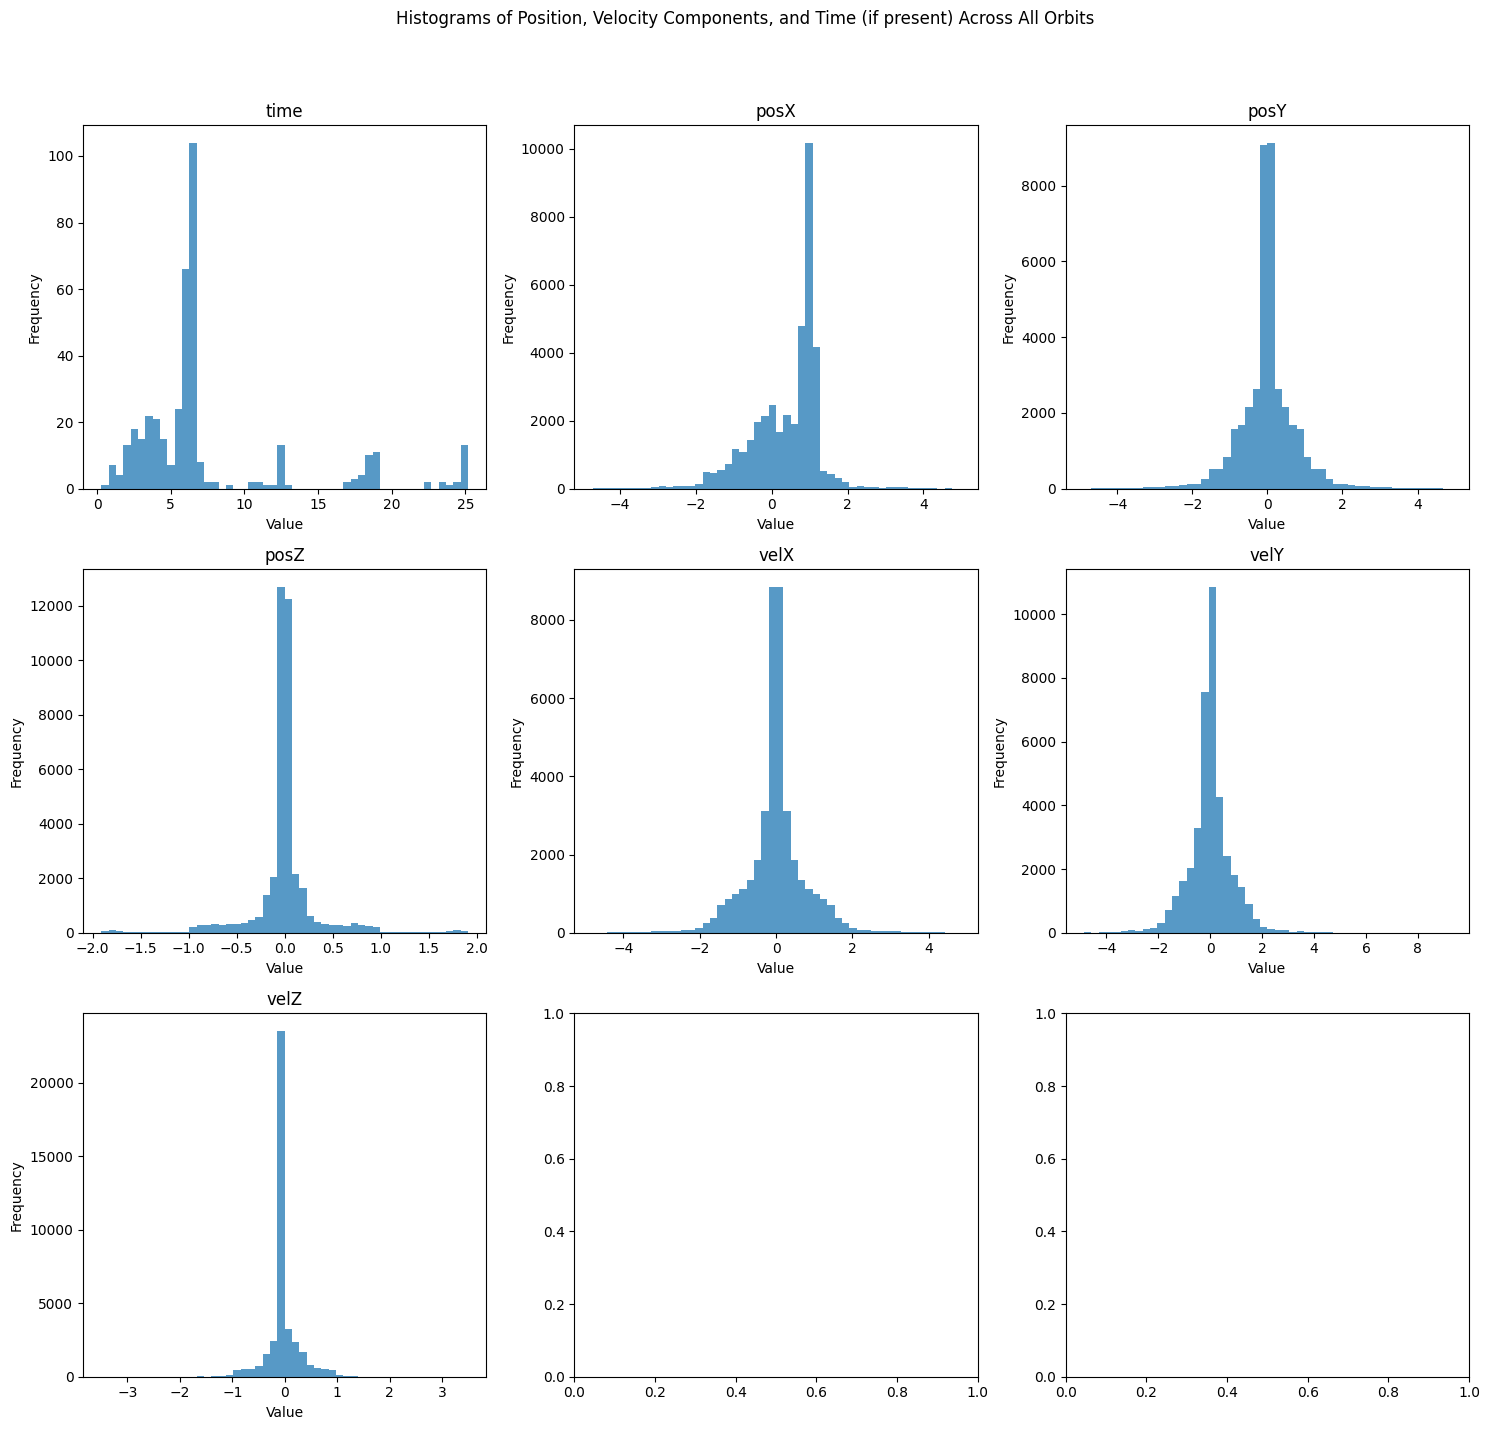

In [ ]:
#| test plot_histograms_position
plot_histograms_position(orbit_data)

In [ ]:
#| export
def plot_histograms_comparison(data1: np.ndarray,  # First orbit data array of shape (num_orbits, num_scalars, num_time_points).
                               data2: np.ndarray,  # Second orbit data array of shape (num_orbits, num_scalars, num_time_points).
                               label1: str = "Dataset 1",  # Label for the first dataset.
                               label2: str = "Dataset 2",  # Label for the second dataset.
                               save_path: str = None,  # Optional path to save the plot image.
                               normalize: bool = False  # Normalize histograms to show relative frequencies.
                               ) -> None:
    """
    Plots histograms for scalar values (position, velocity in X, Y, Z, and optionally time) from two datasets on 
    the same chart with different colors. Supports both 6 and 7 scalar dimensions, with the 7th being 'time'.
    Optionally saves the plot to a specified file path and can normalize histograms for relative comparison.
    """
    # Check the number of scalars and adjust scalar names accordingly
    num_scalars = data1.shape[1]
    scalar_names = ['posX', 'posY', 'posZ', 'velX', 'velY', 'velZ']
    if num_scalars == 7:
        scalar_names.insert(0, 'time')

    if num_scalars not in [6, 7]:
        raise ValueError("Data arrays must have either 6 or 7 scalar dimensions.")

    # Setting up the subplot grid
    rows, cols = (3, 3) if num_scalars == 7 else (2, 3)
    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    fig.suptitle('Comparative Histograms of Position, Velocity Components, and Time (if present)')

    # Plot histograms
    for i in range(num_scalars):
        scalar_values1 = data1[:, i, :].flatten()
        scalar_values2 = data2[:, i, :].flatten()
        row, col = divmod(i, 3)
        
        density = normalize  # Use the same variable for clarity in the hist function call
        axs[row, col].hist(scalar_values1, bins=50, alpha=0.75, color='blue', label=label1, density=density)
        axs[row, col].hist(scalar_values2, bins=50, alpha=0.75, color='green', label=label2, density=density)
        
        axs[row, col].set_title(scalar_names[i])
        axs[row, col].set_ylabel('Density' if normalize else 'Frequency')
        axs[row, col].set_xlabel('Value')
        axs[row, col].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Saving or showing the plot
    if save_path:
        plt.savefig(save_path)
    plt.show()

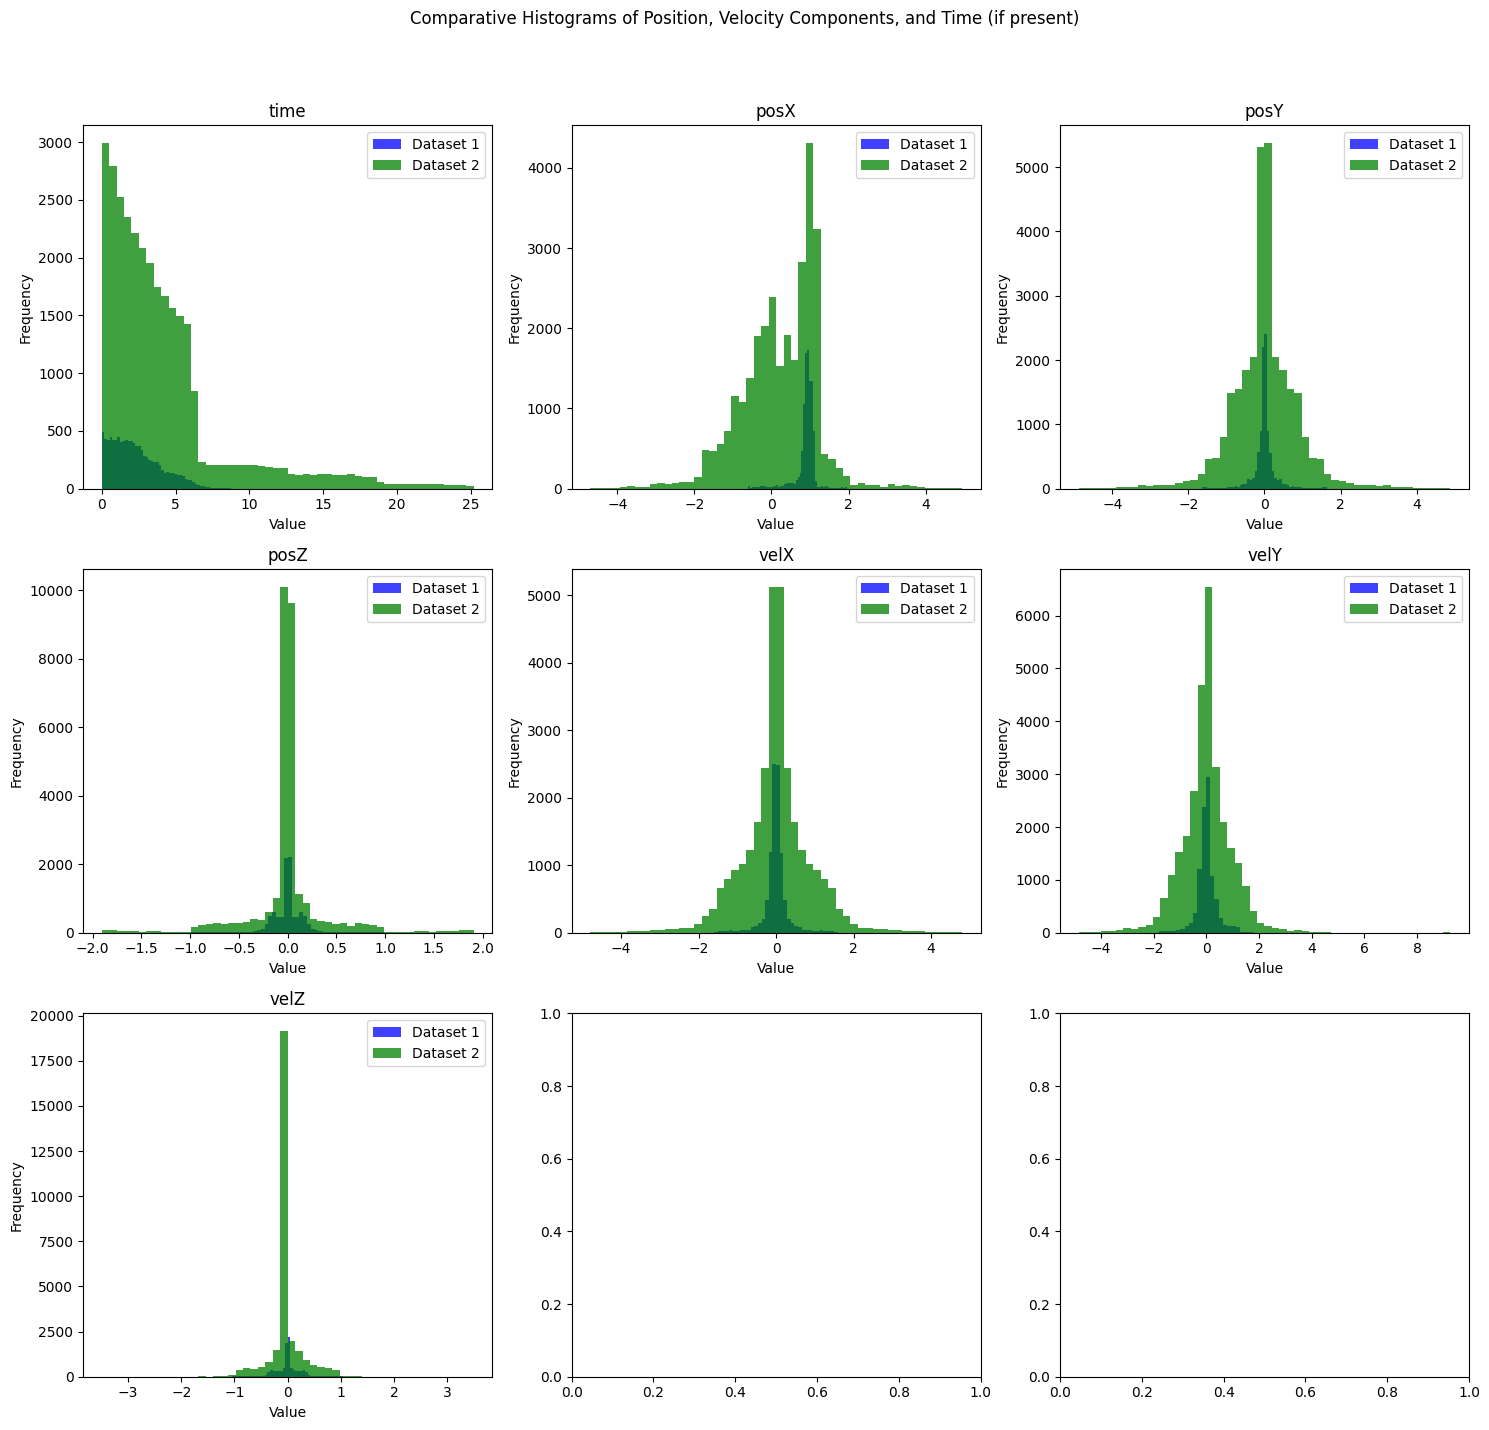

In [ ]:
#| test plot_histograms_comparison
orbit_data1 = orbit_data[:100]
orbit_data2 = orbit_data[100:]

plot_histograms_comparison(orbit_data1, orbit_data2)

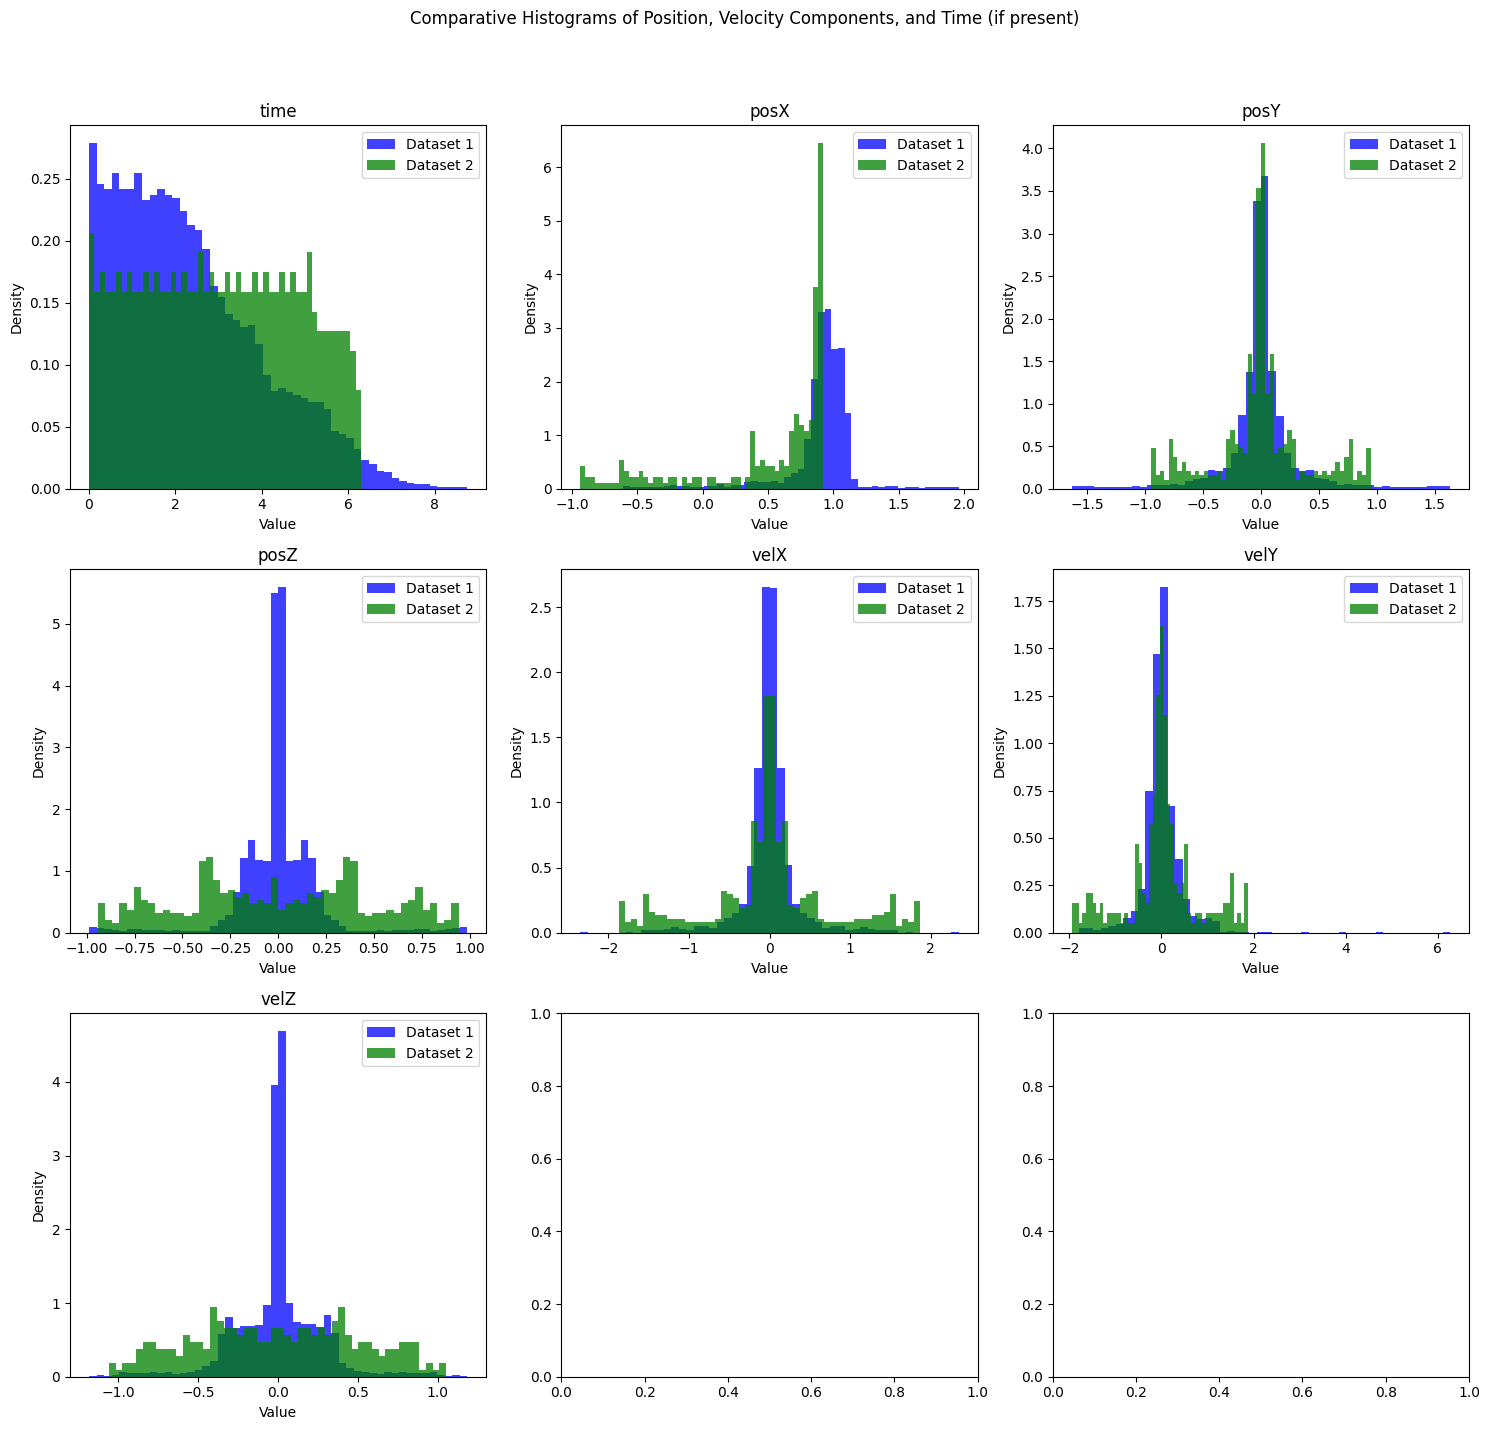

In [ ]:
orbit_data3 = orbit_data2[:5]

plot_histograms_comparison(orbit_data1, orbit_data3, normalize=True)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()